In [69]:
import pickle
import numpy as np
from re import split
from wordcloud import WordCloud

In [70]:
data = pickle.load(open("emotype_v10_depression_cluster.p", "rb" ))
print("num samples",len(data))
# https://python-graph-gallery.com/wordcloud/

num samples 22484


In [71]:
class tfidf():
    
    def __init__(self,data,label_cluster_dic):
        
        self.tfidf_mat = None
        self.data = data
        self.label_cluster_dic = label_cluster_dic
        all_text = []  # List to contain all of the words (our lexicon)
        for i in range(len(data)):
            tmp = data[i]['text'].strip().lower()
            all_text.append(split("[^a-zA-Z']+", tmp))

        dic = {}
        for i in range(len(all_text)):  # i_th word in our lexicon
            for j in all_text[i]:  #j
                if j and dic.get(j, -1) != 0:
                    dic[j] = 0
        self.dic = dic
        self.word_list = list(dic.keys())
    
    def find_text_with_cluster(self, cluster_idx):
        '''input: class index (integer)
           output: list of phrases where each phrase is itself a list of word strings'''
        str_list = []
        for i in range(len(data)):
            if data[i]['cluster'] == cluster_idx:
                str_list.append(split("[^a-zA-Z']+", data[i]['text'].strip().lower() ))
        return str_list

    def count_word_of_cluster(self, str_list):
        '''returns a dictionary of counts for each word in the vocabulary'''
        count_dic = dict.fromkeys(self.dic,0) # make a copy of dic, prefilled wiht 0 count
        for phrase in str_list:
            for word in phrase:
                if word: count_dic[word] += 1 # if string is not empty,'', increment count
        return count_dic

    def get_cluster_vectors(self, word_list, count_dic):
        '''input: list of strings and dictionary of word counts
           output: vector of integers representing counts for each word in wordlist'''
        out = []
        for word in word_list:  
            out.append(count_dic[word])
        return out

    def extract_vectors(self, cluster):
        text_cluster = self.find_text_with_cluster(cluster)
        dic_cluster = self.count_word_of_cluster(text_cluster)
        vector_cluster = self.get_cluster_vectors(self.word_list,dic_cluster)
        return vector_cluster
    
    def make_tfidf_mat(self):
    
        num_clusters = len(self.label_cluster_dic)  
        num_words_in_lexicon = len(self.word_list)

        # Rows are clusters, columns are words, and elements are word frequencies in the cluster
        word_freq_mat = np.zeros((num_clusters, num_words_in_lexicon))  # < number of classes, vocab size >

        for cluster_name, cluster_label in self.label_cluster_dic.items():
            cluster_freqs = np.array(self.extract_vectors(cluster_label))
            word_freq_mat[cluster_label, :] = cluster_freqs

        # a matrix where each element is the term frequency for the word of the same index 
        # the count is divided by the sum over the row, TF = the word_count/total_word_count

        term_frequency = word_freq_mat / np.sum(word_freq_mat, axis=1, keepdims=True)

        # axis = 1 means you sum across the row and you are left with a column

        epsilon = 0.0001 # smoothing constant 
        # a vector of size vocab_size, where each element is the number of clusters/docs/classes 
        # that has greater than 0 instances of the word that has the same index as that element 

        num_clusters_with_word_present = np.sum(word_freq_mat > 0, axis=0, keepdims=True)

        # num_clusters_with_word_present.shape # (1, vocab_size)

        idf = np.log(num_clusters / (num_clusters_with_word_present + epsilon))

        self.tfidf_mat = term_frequency * idf 

        # tfidf.shape = (num_classes, vocab_size)
    
    def get_top_n_tfidf(self, n, cluster_idx):
        if self.tfidf_mat is None:
            print(" calculating tfidf...")
            self.make_tfidf_mat()
        top_n_tfidf = np.argsort(self.tfidf_mat, axis=1)[:, -n:]
        return [self.word_list[i] for i in list(top_n_tfidf[cluster_idx, :])]
    
    def get_top_n_tfidf_dict(self, n, cluster_idx):
        if self.tfidf_mat is None:
            print(" calculating tfidf...")
            self.make_tfidf_mat()
        top_n_tfidf = np.argsort(self.tfidf_mat, axis=1)[:, -n:]
        freq_dict = {}
        for i in list(top_n_tfidf[cluster_idx, :]):
            freq_dict[self.word_list[i]] = self.tfidf_mat[cluster_idx,i]
        return freq_dict

In [73]:
cluster_set = set()
cluster_dict = {}

for i in range(len(data)):
    
    cluster_dict[str(data[i]['cluster'])] = data[i]['cluster']
    cluster_set.add(data[i]['cluster'])

print(cluster_set)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [74]:
tfidf_data = tfidf(data,cluster_dict)

In [76]:

print(word_dict)

{'bendy': 5.5398084185431637e-05, "surei'm": 5.5398084185431637e-05, 'suredo': 5.5398084185431637e-05, 'hormonal': 5.5398084185431637e-05, 'rejection': 5.601452182543135e-05, 'depressive': 6.440242729799217e-05, 'suicide': 6.550332349112024e-05, 'mais': 6.924760523178954e-05, 'mania': 7.504387700439381e-05, 'bulbs': 8.309712627814745e-05, 'craziness': 8.309712627814745e-05, 'urges': 8.35378024870386e-05, 'moods': 8.652536706513576e-05, 'swings': 9.802541319450487e-05, 'rage': 0.00010474123381569065, 'lithium': 0.00013849521046357908, 'que': 0.000152344731509937, 'manic': 0.00015938883406735536, 'borderline': 0.00016944124395107935, 'impulsive': 0.00019692466944162644}


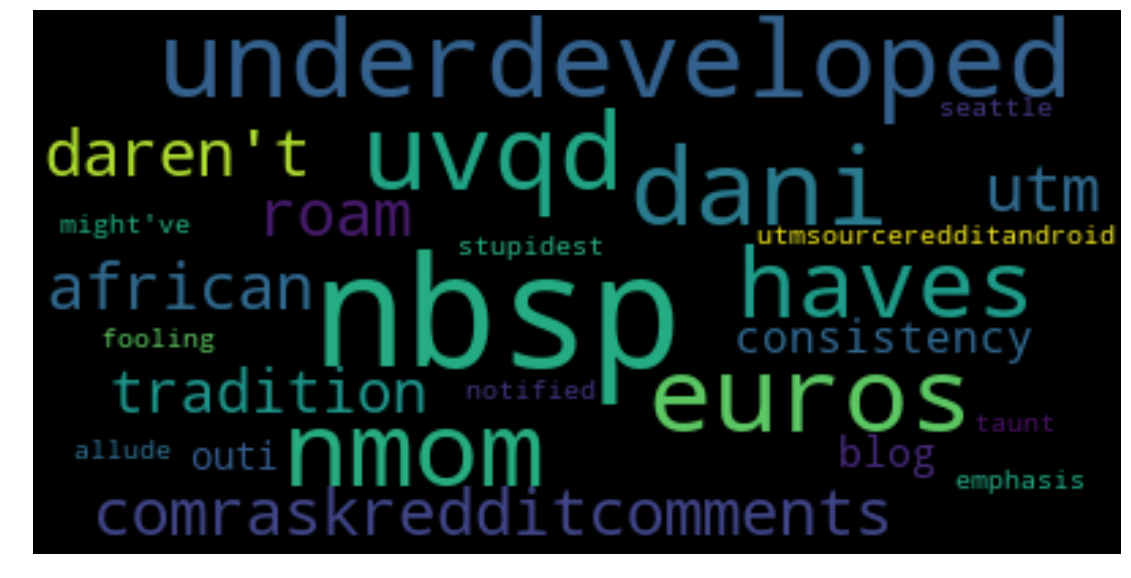

In [89]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline  

word_dict = tfidf_data.get_top_n_tfidf_dict(25, cluster_dict['5'])
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()